In [ ]:
################################################################
###                          setup                            ##
################################################################
!cd /content/
!mkdir /content/Input/
!mkdir /content/Output/
!mkdir /content/Model

In [ ]:
#connecting my drive
import os,sys
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bin='/content/drive/MyDrive/server'
sys.path.append(bin)

In [ ]:
#!pip install tensorflow==2.4.0 keras==2.4.3 numpy==1.19.3 pillow==7.0.0 scipy==1.4.1 h5py==2.10.0 matplotlib==3.3.2 opencv-python keras-resnet==0.2.0

In [ ]:
#!pip install --target=bin imageai --upgrade

In [ ]:
import tensorflow as tf

In [ ]:
import imageai

In [ ]:
def input_image_path():
  path="/content/drive/MyDrive/ESP32-CAM/"
  dir_list = os.listdir(path)
  #print("Files and directories in '", path, "' :")
  sorted(dir_list,reverse=True)
  #print("No of image",len(dir_list))
  return path+dir_list[0]

def show_image(x):
  img = Image.open(x)
  img.show(img)
  display(img)

our Input file at variable input_image

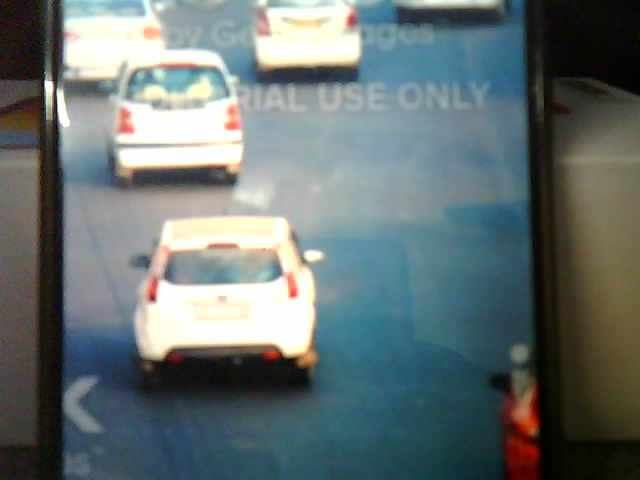

In [ ]:
show_image(input_image_path())




```
# Import ObjectDetection class from the ImageAI library.
create model
# if you use YOLOv3 model, call the following method
# function which accepts a string which contains the path to the pre-trained model.
# Loads the model from the path specified above using the setModelPath() class method.
  
run
# function returns a dictionary which contains the names and percentage probabilities of all the objects detected in the image.
# The dictionary items can be accessed by traversing through each item in the dictionary.


#"/content/Input/1.png"
```



In [ ]:
from numba import jit, cuda
def create_Model(m):
  print("[INFO] Model create start...")
  detector = ObjectDetection()
  detector.setModelTypeAsYOLOv3()
  detector.setModelPath(m)
  detector.loadModel()
  print("[INFO] Model created...")
  return detector


# @ jit
def run(i,o,detector):
  #print("[INFO] object detection start ...")
  detection = detector.detectObjectsFromImage(input_image=i, output_image_path=o)
  #  just for debug
  #for eachItem in detection:
  #  print(eachItem["name"] , " : ", eachItem["percentage_probability"])
  #print("[INFO] object detection done ...")
  return detection


def result(detection):
  print("[INFO] result caluclated")
  #calculate cars no.and persons
  count_cars=0
  count_persons=0
  count_bikes=0
  count_bus=0
  # print(eachItem["name"] , " : ", eachItem["percentage_probability"])

  for eachItem in detection:
      if eachItem["name"]=='car':
        count_cars+=1
      if eachItem["name"]=='person':
        count_persons+=1
      if eachItem["name"]=='bike':
        count_bikes+=1
      if eachItem["name"]=='bus':
        count_bus+=1
  # just for debug
  #print('count of cars are :',count_cars)
  #print('count of persons are :',count_persons)
  #print('count of bike are :',count_bikes)

  return int(count_bikes+count_cars+count_bus)

In [ ]:

def model(mpath,ipath,opath):
  detect=create_Model(mpath)
  object_probability=run(ipath,opath,detect)
  return result(object_probability)

In [ ]:
################################################################
###                      Ubidot communication                 ##
################################################################
import time
import requests
import math
import random

TOKEN = "BBFF-oridfscoPfCkZmL2301z4cqZIHVgPS"  # Put your TOKEN here
DEVICE_LABEL = "traffic"  # Put your device label here
VARIABLE_LABEL_1 = "path1"  # Put your first variable label here
VARIABLE_LABEL_2 = "path2"  # Put your second variable label here
VARIABLE_LABEL_3 = "path3"  # Put your third variable label here
VARIABLE_LABEL_4 = "path4"  # Put your forth variable label here
VARIABLE_LABEL_5 = "flag"  # Put your forth variable label here

def build_payload(variable_1, variable_2, variable_3 ,variable_4,variable_5,data):
    # Creates random values for sending data
    value_1 = data[0]
    value_2 = data[1]
    value_3 = data[2]
    value_4 = data[3]
    flag = int(time.time())

    #json format
    payload = {variable_1: value_1,
               variable_2: value_2,
               variable_3: value_3,
               variable_4: value_4,
               variable_5: flag
               }

    return payload


def post_request(payload):
    # Creates the headers for the HTTP requests
    url = "http://industrial.api.ubidots.com"
    url = "{}/api/v1.6/devices/{}".format(url, DEVICE_LABEL)
    headers = {"X-Auth-Token": TOKEN, "Content-Type": "application/json"}

    # Makes the HTTP requests
    status = 400
    attempts = 0
    while status >= 400 and attempts <= 5:
        req = requests.post(url=url, headers=headers, json=payload)
        status = req.status_code
        attempts += 1
        time.sleep(1)

    # Processes results
    print(req.status_code, req.json())
    if status >= 400:
        print("[ERROR] Could not send data after 5 attempts, please check \
            your token credentials and internet connection")
        return False

    print("[INFO] request made properly, your device is updated")
    return True


def sent_to_ubidots(data):
    payload = build_payload(
        VARIABLE_LABEL_1,
        VARIABLE_LABEL_2,
        VARIABLE_LABEL_3,
        VARIABLE_LABEL_4,
        VARIABLE_LABEL_5,
        data)

    print("[INFO] Attemping to send data")
    post_request(payload)
    print("[INFO] finished")


In [ ]:


def dynamic(data):
  res=[0,0,0,0]
  a=set()
  print(a)
  max_val=len(a)
  for i in range( len(data)):
    t=data.index(max(data))
    data[t]=-1
    res[t]=max_val
    max_val-=1
  return res
x=[8,3,6,8]
dynamic(x)

In [ ]:
################################################################
###                          run                              ##
################################################################

from imageai.Detection import ObjectDetection
res=[0,0,0,0]

mpath="/content/drive/MyDrive/server/Model/yolo.h5"

opath = ["/content/Output/newimage1.jpg",
         "/content/Output/newimage2.jpg",
         "/content/Output/newimage3.jpg",
         "/content/Output/newimage4.jpg"
         ]

ipath = ["/content/drive/MyDrive/server/sample/s0.PNG",
         "/content/drive/MyDrive/server/sample/s2.jpeg",
         "/content/drive/MyDrive/server/sample/s1.jpeg",
         "/content/drive/MyDrive/server/sample/s2.jpeg"
         ]

ipath[0] = input_image_path()                        # input file fetch from esp32  as path1
epoch=1
for e in range(0, epoch):
  print("epoch:",e)
  for i in range(0,4):
    res[i]=model(mpath,ipath[i],opath[i])
    print("[INFO]  trafic light... [",i,"] is Done")
  print("[INFO] result :",res)
  print("-"*40)
  sent_to_ubidots(res);

epoch: 0
[INFO] Model create start...
[INFO] Model created...
1/1 [==============================] - 9s 9s/step
[INFO] result caluclated
[INFO]  trafic light... [ 0 ] is Done
[INFO] Model create start...
[INFO] Model created...
1/1 [==============================] - 1s 925ms/step
[INFO] result caluclated
[INFO]  trafic light... [ 1 ] is Done
[INFO] Model create start...
[INFO] Model created...
1/1 [==============================] - 1s 950ms/step
[INFO] result caluclated
[INFO]  trafic light... [ 2 ] is Done
[INFO] Model create start...
[INFO] Model created...
1/1 [==============================] - 1s 954ms/step
[INFO] result caluclated
[INFO]  trafic light... [ 3 ] is Done
[INFO] result : [3, 37, 24, 37]
----------------------------------------
[INFO] Attemping to send data
200 {'flag': [{'status_code': 201}], 'path1': [{'status_code': 201}], 'path2': [{'status_code': 201}], 'path3': [{'status_code': 201}], 'path4': [{'status_code': 201}]}
[INFO] request made properly, your device is u

In [ ]:
################################################################
###                          done                             ##
################################################################
print("---------------------DONE-------------------------")

In [ ]:
show_image(opath)

In [ ]:
#in case model not found
#%cd /content/Model
#!wget https://github.com/OlafenwaMoses/ImageAI/releases/download/1.0/yolo.h5
#mpath="/content/Model/yolo.h5"

In [ ]:
print(res)

In [ ]:
res

In [ ]:
from imageai.Detection import ObjectDetection

mpath="/content/drive/MyDrive/server/Model/yolo.h5"
#ipath = input_image_path()                        # input file fetch from esp32
opath = "/content/Output/newimage.jpg"
ipath ="/content/drive/MyDrive/server/sample/s1.jpeg"
res[0]=model(mpath,ipath,opath)
print(res[0])